Build a model to predict a patient's short term disease progression based on the nucleotide sequences of two enzymes and 2 other scalar patient parameters. Use the dataset that was used in an old Kaggle competition located here:
https://www.kaggle.com/c/hivprogression/data

The solution to the competition is present on the site, but I did not examine the solution nor any of the submitted notebooks. I developed the solution presented here independently.

I first do a prelimary exploration of the data. This is followed by a number of feature engineering steps that involve transformations of the data.

Develop a model and experiment with various parameters. Evaluate the parameter combinations using hold out validation with the StratifiedKFold class using only the training set. For each best combination, run predictions on the test set to get an accuracy score.

The code is organized into a series of classes and functions that can be used to perform the various data transformation and model testing tasks required.

In [225]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import numpy as np

train_df = pd.read_csv("training_data.csv")


Let's get some general information about the data.

In [226]:
train_df.describe()

,PatientID,Resp,VL-t0,CD4-t0
count,1000.000000,1000.000000,1000.00000,1000.000000
mean,500.500000,0.206000,4.29721,279.638000
std,288.819436,0.404633,0.70478,198.186712
min,1.000000,0.000000,2.70000,0.000000
25%,250.750000,0.000000,3.70000,132.750000
50%,500.500000,0.000000,4.30000,249.000000
75%,750.250000,0.000000,4.80000,383.250000
max,1000.000000,1.000000,6.00000,1589.000000


In [227]:
train_df.isnull().sum()

PatientID     0
Resp          0
PR Seq       80
RT Seq        0
VL-t0         0
CD4-t0        0
dtype: int64

In [228]:
train_df = train_df.dropna()

In [229]:
train_df['PR Seq'].str.len().value_counts(bins=6)

(283.5, 297.0]      905
(256.5, 270.0]       10
(243.0, 256.5]        3
(270.0, 283.5]        1
(215.918, 229.5]      1
(229.5, 243.0]        0
Name: PR Seq, dtype: int64

In [230]:
train_df['RT Seq'].str.len().value_counts(bins=6)


(880.0, 1030.5]     544
(729.5, 880.0]      228
(1331.5, 1482.0]    120
(1030.5, 1181.0]     14
(578.096, 729.5]     14
(1181.0, 1331.5]      0
Name: RT Seq, dtype: int64

There are 1000 rows with 80 of the rows having null values in one of the columns, PR Seq. As this is a small percentage of the total and there are no rows with null values in any of the columns in the test dataset, the rows are simply dropped.

The two nucleotide sequence columns have variable length distributions. The PR Seq column is pretty uniform with only a small percentage of rows having lengths less than 283. However, the RT Seq column has a more variable length distribution. In case the length of the RT Seq column might have some bearing on the model result, a new category column is created that classifies each row based upon the length of the RT Seq column.


Let's now examine the distribution of values of the 2 structured feature columns.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022CF87AC248>,
      dtype=object)

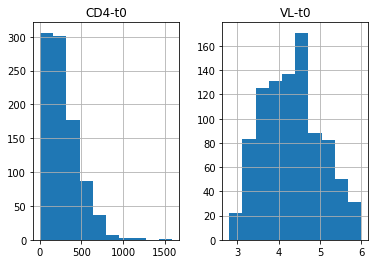

In [231]:
train_df[['VL-t0', 'CD4-t0']].hist()

Because the distribution of values for the two structured columns vary widely over large ranges we will standardize their distributions to z values.

The sequences we are dealing with are nucleotide sequences. Each nucleotide base in the sequence is represented by a separate letter in the string. We encode each nucleotide letter into a unique integer. We then use a one hot encoding technique to translate each unicode value into a one hot vector which can be used by our model.

Another approach that we did not experiment with in this project would have been to group the letters of the sequence into fixed overlapping character length groupings called k-mers in bioinformatics terminology. In this case we would treat each k-mer like we would separate words in a sentence in a machine learning natural language processing application and encode each k-mer into an embedding vector.


We divide our features into structured or scalar features, VL-t0 and CD4-t0, and sequence features, PR Seq and RT Seq. Structured features can be modelled using models such as linear regression and dense neural networks. Sequences such as PR Seq and RT Seq, on the other hand, are best suited to models specifically designed for sequences such as RNN's or CNN's. CNN's are primarily used for image classification but they are also very effective at modelling sequences.

Our strategy is to use a neural net model that can handle both scalar features and sequences. The model will have 3 separate inputs.

- Input_structured - This will consist of the two scalar features
- Input_prseq - This will be the PR Seq column
- Input_rtseq - This will be the RT Seq column

Each input will be fed into a subnetwork of our model that is designed to handle that particular input type. The input_structured input will be fed into a dense subnetwork. The two sequence inputs will be fed into two separate subnetworks specialized to handle sequences. The outputs of the 3 subnetworks will eventually be combined and fed into a final dense output layer that will compute the result.

Each of the sequence columns will have their own subnetwork because sequences are best handled by their own dedicated network. We will use a CNN for the sequences.

We now define a set of classes and functions that we will use later on in the notebook.

In [232]:
def dataset_to_numpy_array(ds):
    """
    Create a 2d numpy array from a dataset.
    First we create a list of lists where the nested lists are created from the
    rows of the dataset.
    We then convert this to a 2d numpy array.

    Parameters
    ----------
    ds:
        Dataset to be converted
    Returns
    -------
    np array
    """
    ds_list = []
    for d in ds:
        ds_list.append(d.numpy().tolist())
    return np.array(ds_list)


In [233]:
class NucleotideVocabulary:
    """
    A wrapper class for a StaticVocabularyTable which maps nucleotide base letters to
    integer ids used to encode our nucleotide sequences.
    
    Parameters
    ----------
    vocab_table: StaticVocabularyTable
        Table of nucleotide base letter/integer id mappings
    num_oov_buckets: integer
        Number of out of vocabulary buckets in vocab_table.
    
    Attributes
    ----------
    vocab_table :
    num_oov_buckets :
    size :
        Size of vocab_table
    """
    def __init__(self,vocab_table, num_oov_buckets):
        self.vocab_table = vocab_table
        self.num_oov_buckets = num_oov_buckets
        
    @property
    def size(self):
        return self.vocab_table.size().numpy()

In [234]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from enum import IntEnum
from itertools import chain
import tensorflow_datasets as tfds

class DataWorkFlow:
    """
    Work flow class for preparing data from a file to be used to test a model.
    We use this class by creating an instance of it and calling the prepare_data
    method. This populates a set of attributes that contain the transformed
    data.
    
    Parameters
    ----------
    file_name: string
        Path of file containing data
    is_test_file : boolean
        Is the file a test file? If False it is considered a training set file.
    nucleotide_vocab : NucleotideVocabulary
        Optional vocabulary table that maps nucleotide base letters to unique
        integer ids. If None, then the table is built by the prepare_data method.
    pr_seq_max_len : The maximum length of a nucleotide sequence in the PR Seq
        column. If None, then value is computed by prepare_data.
    rt_seq_max_len : The maximum length of a nucleotide sequence in the RT Seq
        column. If None, then value is computed by prepare_data.

    Attributes
    ----------
    nucleotide_vocab : NucleotideVocabulary
        Vocabulary table that maps nucleotide base letters to unique
        integer ids.
    pr_seq_max_len : The maximum length of a nucleotide sequence in the PR Seq
        column.
    rt_seq_max_len : The maximum length of a nucleotide sequence in the RT Seq
        column.
    structured_data : 2d numpy array
        array of scaled values of the 'VL-t0', 'CD4-t0' columns.
    pr_seq_data : 2d numpy array
        array of encoded PR Seq values
    rt_seq_data : 2d numpy array
        array of encoded RT Seq values
    labels :
        array of labels
    """

    class State(IntEnum):
        """
        Enum specifying various states of the work flow. Used to force methods to
        be called in the right order.
        """
        INIT = 5
        LOADED = 10
        PRE_PREPARED = 20
        ADJUSTED_RESPONSE_DIST = 30
        SCALED_COLUMNS = 40
        REMOVED_OUTLIERS = 50
        ENCODED_SEQS = 60
        
    def _validate_state(self,minimum_state):
        """
        Ensure that current state is this state or later in the work flow.
        Parameters
        ----------
        minimum_state : must be in this state or higher
        Returns
        -------
        C : array, shape (n_samples,)
            Returns predicted values.
        """
        if self._state < minimum_state:
            raise Exception(f'Workflow must have reached a minimum state of {minimum_state.name},{minimum_state} '+
                           f'in order to call this method and it is currently at {self._state.name},{self._state}')
        
    def __init__(self,file_name,is_test_file=False,nucleotide_vocab=None,pr_seq_max_len=None,
                rt_seq_max_len=None):
        if (file_name == None):
            raise Exception("file name is required in constructor")
        self._file_name = file_name
        self._state = self.State.INIT
        self.nucleotide_vocabulary = nucleotide_vocab
        self._removed_outlier_row_count = 0
        self._is_test_file = is_test_file
        self.pr_seq_max_len = pr_seq_max_len
        self.rt_seq_max_len = rt_seq_max_len
        self._resp_1_row_count = None
        self._resp_0_row_count = None

    def assign_rt_cat(self,rt_seq_len):
        """
        Assign a category based on the length of an RT Seq nucleotide sequence.
        We use it to perform stratified sampling when doing
        hold out training/testing because of the possible effect of sequence length
        on the result.
        
        Parameters
        ----------
        rt_seq_len : integer
            length of sequence
        """
        if 849 <= rt_seq_len <= 940:
            return 'C849'
        elif 1391 <= rt_seq_len <= 1482:
            return 'C1391'
        elif 941 <= rt_seq_len <= 1030:
            return 'C941'
        elif 669 <= rt_seq_len <= 759:
            return 'C699'
        elif 759 <= rt_seq_len <= 849:
            return 'C759'
        else:
            return 'C1030'
        
    def adjust_response_distribution(self,zero_response_fraction=.4):
        """
        Adjust the distribution of rows in the dataset in order to achieve
        a target distribution of values in the label column, Resp.
        For example, if a value of .4 is passed for zero_response_fraction this
        method will ensure that 40% of the rows in the dataset stored in the
        _feature_dataframe attribute will have a Resp value of 0.
        It accomplishes this by removing rows with a Resp value of 0 to obtain
        the target fraction. If the fraction of Resp 0 rows is less than 
        what would be required to achieve the target fraction, then no rows are
        removed and we do not adjust the distribution. We assume
        that we have more than enough Resp 0 rows in the dataset.
        
        Parameters
        ----------
        zero_response_fraction : number
            desired target fraction of rows with Resp = 0
        """
        self._validate_state(self.State.PRE_PREPARED)
        #Create RT Cat column that categories rows based upon the length of the RT Seq column
        #This is used to do stratified sampling.
        self._feature_dataframe.loc[:,'RT Cat'] = \
            self._feature_dataframe['RT Seq'].str.len().apply(self.assign_rt_cat)

        data_1 = self._feature_dataframe[self._feature_dataframe['Resp']==1]
        data_0 = self._feature_dataframe[self._feature_dataframe['Resp']==0]

        #If the fraction of Resp 0 rows is less than target fraction, then
        #do not remove any Resp 0 rows.
        #We remove the excess Resp 0 rows by using train_test_split passing
        #the fraction of rows to preserve as the train_size. This allows us
        #to obtain a random sample of the rows using stratified sampling based
        #upon the RT Cat column.
        if len(data_0)/(len(data_0) + len(data_1)) > zero_response_fraction:
            data_0_size = (zero_response_fraction*len(data_1)/
              (len(data_0)*(1-zero_response_fraction)))
            data_0, _ = train_test_split(data_0, train_size=data_0_size,
                                            shuffle=True,stratify=data_0[['RT Cat']])

        data = pd.concat([data_1,data_0])
        new_indexes = np.random.permutation(data.index)
        self._feature_dataframe = data.loc[new_indexes].reset_index(drop=True)
        self.labels = self._feature_dataframe['Resp']
        self._resp_1_row_count = len(data_1)
        self._resp_0_row_count = len(data_1)
        self._state = self.State.ADJUSTED_RESPONSE_DIST
        
    
    def load_file(self):
        """
        Loads file into dataframe
        """
        self._dataframe = pd.read_csv(self._file_name)
        self._state = self.State.LOADED
    
    def pre_prepare_data(self):
        """
        Initial preparation of data. Creates a _feature_data dataframe for features
        and a labels dataframe for encoded labels.
        """
        self._validate_state(self.State.LOADED)
        self._feature_dataframe = self._dataframe.dropna().copy()
        if not self._is_test_file:
            self.labels = self._feature_dataframe['Resp']
        self.pr_seq_max_len = self._feature_dataframe['PR Seq'].str.len().max()
        self.rt_seq_max_len = self._feature_dataframe['RT Seq'].str.len().max()
        self._state = self.State.PRE_PREPARED

    def prepare_data(self,zero_response_fraction=None,remove_outlier_threshold=4):
        """
        Prepares data calling the various other functions to do specific transformation
        tasks.
        
        Parameters
        ----------
        zero_response_fraction : number
            see adjust_response_distribution
        remove_outlier_theshold : number
            Remove rows with a standardized z value in any of its numeric attributes
            greater than this value.
        """
        self.pre_prepare_data()
        if not self._is_test_file and zero_response_fraction != None:
            self.adjust_response_distribution(zero_response_fraction)
        else:
            self._state = self.State.ADJUSTED_RESPONSE_DIST
        self.scale_columns()
        if not self._is_test_file:
            self.remove_outliers(remove_outlier_threshold)
        else:
            self._state = self.State.REMOVED_OUTLIERS
        self.encode_nucleotide_sequences()
            
    def scale_columns(self):
        """
        Scales feature columns to z scores.
        The scaled values are stored in the structured_data attribute.
        """
        self._validate_state(self.State.ADJUSTED_RESPONSE_DIST)
        structured_cols = ['VL-t0', 'CD4-t0']
        standardScaler = StandardScaler()
        scaled_data = standardScaler.fit_transform(self._feature_dataframe[structured_cols])
        #self._structured_ds = tf.data.Dataset.from_tensor_slices(scaled_data)
        self.structured_data = scaled_data
        self._state = self.State.SCALED_COLUMNS
    
    def encode_nucleotide_sequences(self):
        """
        Encode a nucleotide sequence for use in a model.
        First convert each base letter to a unicode value.
        Then create a StaticVocabularyTable mapping each
        unicode value to a unique id.
        We then use this table to encode the sequence using these
        unique ids.
        
        I experimented using tensorflow datasets for the sequences.
        However, I could not figure out how to pass multiple inputs
        to the model.fit method using datasets. The documentation was nonexistent
        on this topic and google searches did not provide any answers
        that worked. So in the end I converted the datasets back to
        numpy arrays.
        """
        self._validate_state(self.State.REMOVED_OUTLIERS)
        rt_seq_tokenized_ds = self.tokenize_nucleotide_seq(
            self._feature_dataframe['RT Seq'], self.rt_seq_max_len)
        pr_seq_tokenized_ds = self.tokenize_nucleotide_seq(
            self._feature_dataframe['PR Seq'], self.pr_seq_max_len)
        if self.nucleotide_vocabulary == None:
            self.nucleotide_vocabulary = \
                self.create_nucleotide_base_vocab_table([pr_seq_tokenized_ds,
                                               rt_seq_tokenized_ds])
        pr_seq_encoded_ds = pr_seq_tokenized_ds.map(
            lambda seq: self.nucleotide_vocabulary.vocab_table.lookup(seq))
        rt_seq_encoded_ds = rt_seq_tokenized_ds.map(
            lambda seq: self.nucleotide_vocabulary.vocab_table.lookup(seq))
        self.pr_seq_data = dataset_to_numpy_array(pr_seq_encoded_ds)
        self.rt_seq_data = dataset_to_numpy_array(rt_seq_encoded_ds)
        self._state = self.State.ENCODED_SEQS
        
    def tokenize_nucleotide_seq(self, seq_series, seq_len):
        """
        Convert each base letter in a nucleotide sequence to the letter's
        unicode value. Right-pad the sequence to seq_len first.
        
        Parameters
        ----------
        seq_series : 
            Pandas series of nucleotide sequences
        seq_len :
            Length to which we must pad each sequence if it is shower than this.
            
        Returns
        -------
        encoded sequence
            A dataset of sequences in which each nucleotide base letter is encoded
            as a unicode value.
        """
        seq_ds = tf.data.Dataset.from_tensor_slices(
            seq_series.str.pad(width=seq_len, side='right', fillchar=' ')
            .values)
        seq_tokenized_ds = seq_ds.map(lambda x: tf.strings.unicode_split(x,'UTF-8'))
        return seq_tokenized_ds

    def create_nucleotide_base_vocab_table(self,seq_tokenized_ds_list):
        """
        Creates a StaticVocabularyTable that maps the unicode value of
        a nucleotide base letter to a unique integer id.
        It populates the table from a dataset of unicode value encoded
        nucleotide sequences.
        
        Parameters
        ----------
        seq_tokenized_ds_list :
            A list of datasets. Each dataset consists of nucleotide sequences in 
            which the nucleotide base letters are represented as their unicode
            equivalents.
        
        Returns
        -------
        NucleotideVocabulary
            A wrapper class for a StaticVocabularyTable mapping table.
        """
        vocab = Counter()
        for d in chain(*seq_tokenized_ds_list):
            vocab.update(list(d.numpy()))
        bases = tf.constant(list(vocab.keys()))
        base_ids = tf.range(len(vocab), dtype=tf.int64)
        base_key_val = tf.lookup.KeyValueTensorInitializer(bases,base_ids)
        num_oov_buckets=1
        table = tf.lookup.StaticVocabularyTable(base_key_val,num_oov_buckets)
        return NucleotideVocabulary(table, num_oov_buckets)
    
    def remove_outliers(self, std_threshold=4):
        """
        Removes rows where any of the columns in the structured_data
        np array have a value that is a certain number of standard
        deviations away from the mean. We assume that the values in
        structured_data have already been standardized to z values.
        
        Parameters
        ----------
        std_threshold : Any rows that have any feature whose 
            value is this many standard deviations away from mean will be 
            removed. If we specify a value of None no rows will be removed.
            We assume that the feature values are z-scores so we do this by 
            simply checking if a value is greater than this value or less than
            the negative of this value to qualify for removal.
        """
        self._validate_state(self.State.ADJUSTED_RESPONSE_DIST)
        self._data_row_count = len(self.structured_data)
        keep_filter = ((self.structured_data.max(axis=1) < std_threshold)
            & (self.structured_data.min(axis=1) > -std_threshold))
        self.structured_data = self.structured_data[keep_filter]
        self._feature_dataframe = self._feature_dataframe[keep_filter].reset_index(drop=True)
        self.labels = self.labels[keep_filter].reset_index(drop=True)
        self._removed_outlier_row_count = (~keep_filter).sum()
        self._state = self.State.REMOVED_OUTLIERS
        
    def display_stats(self):
        """
        Display statistics about data preparation process.
        """
        print(f'Response 1 row count {self._resp_1_row_count}')
        print(f'Response 0 row count {self._resp_0_row_count}')
        print(f'Number of distinct nucleotide bases: {self.nucleotide_vocabulary.size}')
        print(f'\nRemoved {self._removed_outlier_row_count} outlier rows out of ' +
              f'{self._data_row_count} data set rows')
        


In [235]:
import pprint
from sklearn.metrics import precision_score, recall_score,accuracy_score,confusion_matrix
from sklearn.model_selection import StratifiedKFold


class ModelTester:
    """
    Class to facilitate running tests on various models and
    hyperparameter combinations.
    
    The training data is passed in the constructor as 3 separate data sets because
    the model takes the data as 3 separate inputs.

    Parameters
    ----------
    structured_data : 2d array of data containing standardized PR Seq and RT Seq
        columns
    pr_seq_data : np array of encoded PR Seq nucleotide sequences.
    rt_seq_data : np array of encoded RT Seq nucleotide sequences.
    labels : np array of labels
    pr_seq_len : Maximum length of a PR Seq sequence.
    rt_seq_len : Maximum length of a RT Seq sequence.
    num_distinct_nucleotide_bases : 
    num_oov_buckets : Number of out of vocabulary buckets in the 
        StaticVocabularyTable used to map nucleotide bases to unique ids.
    
    Attributes
    ----------
    scores : TestResult
        List of scores for each split in the last call to train_test_model
    
    
    See Also
    --------

    Notes
    -----
    
    Examples
    --------    
    """
    
    class TestResult:
        """
        Value object that contains training and validation scores.

        Parameters
        ----------
        train_score : 
        valid_score :
        train_confusion_matrix :
        valid_confusion_matrix :
        """
        def __init__(self, train_score, valid_score, train_confusion_matrix,
                    valid_confusion_matrix, train_recall, valid_recall,
                    train_specificity, valid_specificity):
            self.train_score = train_score
            self.valid_score = valid_score
            self.train_confusion_matrix = train_confusion_matrix
            self.valid_confusion_matrix = valid_confusion_matrix
            self.train_recall = train_recall
            self.valid_recall = valid_recall
            self.train_specificity = train_specificity
            self.valid_specificity = valid_specificity
        
    def __init__(self, structured_data, pr_seq_data, rt_seq_data, labels,
                pr_seq_len, rt_seq_len, num_distinct_nucleotide_bases,
                num_oov_buckets):
        self._structured_data = structured_data
        self._pr_seq_data = pr_seq_data
        self._rt_seq_data = rt_seq_data
        self._pr_seq_len = pr_seq_len
        self._rt_seq_len = rt_seq_len
        self._num_bases = num_distinct_nucleotide_bases
        self._num_oov_buckets = num_oov_buckets
        self._labels = labels

    def train_validate_model(self,epochs=10):
        """
        Trains a model using hold out validation and stratified sampling.
        It uses the training data passed in the constructor.
        It stores the score for each split in the scores list attribute.
        We rebuild model and compile it for each split in order to 
        start off with brand new weights.
        
        Parameters
        ----------
        epochs :
            training epochs
        """
        scores = []
        confusion_matricies = []
        cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
        i=0
        for train_index, valid_index in cv.split(self._structured_data,
                                                self._labels):
            #print(f"ith run {i}")
            i+=1

            X_train_structured, X_valid_structured = self._structured_data[train_index], \
                self._structured_data[valid_index]
            X_train_pr_seq, X_valid_pr_seq = self._pr_seq_data[train_index], \
                self._pr_seq_data[valid_index]
            X_train_rt_seq, X_valid_rt_seq = self._rt_seq_data[train_index], \
                self._rt_seq_data[valid_index]

            y_train, y_valid = self._labels[train_index], self._labels[valid_index]

            model=build_model(self._num_bases,self._num_oov_buckets,
                              self._pr_seq_len, self._rt_seq_len)
            compile_model(model, len(X_train_structured))

            history=model.fit({'pr_seq':X_train_pr_seq,'rt_seq':X_train_rt_seq,
                               'structured':X_train_structured},
                          y_train,epochs=epochs, verbose=0,
                         validation_data=({'pr_seq':X_valid_pr_seq,'rt_seq':X_valid_rt_seq,
                                           'structured':X_valid_structured},y_valid))
            val_accuracy = history.history['val_accuracy'][-1]
            train_accuracy = history.history['accuracy'][-1]
            val_precision = history.history['val_precision'][-1]
            train_precision = history.history['precision'][-1]
            val_specificity = history.history['val_specificity'][-1]
            train_specificity = history.history['specificity'][-1]
            val_recall = history.history['val_recall'][-1]
            train_recall = history.history['recall'][-1]
            predict = model.predict({'pr_seq':X_train_pr_seq,'rt_seq':X_train_rt_seq,
                                       'structured':X_train_structured})
            predict_round = np.round(predict)
            train_confusion_matrix = confusion_matrix(y_train,predict_round)
            predict = model.predict({'pr_seq':X_valid_pr_seq,'rt_seq':X_valid_rt_seq,
                                       'structured':X_valid_structured})
            predict_round = np.round(predict)
            valid_confusion_matrix = confusion_matrix(y_valid,predict_round)
            scores.append(self.TestResult(train_accuracy, val_accuracy,
                                         train_confusion_matrix,
                                         valid_confusion_matrix,
                                         train_recall,
                                         val_recall,
                                         train_specificity,
                                         val_specificity))

        self.scores = scores
        
    def display_train_validate_scores(self):
        """
        Displays scores for each split generated by last call to
        train_validate_model.
        """
        i=1
        for score in self.scores:
            print(f'split: {i}, train accuracy: {score.train_score}, valid accuracy: {score.valid_score}')
            i+=1
            
    def train_full_model(self,epochs=10):
        """
        Trains a model using the full training data set passed in the constructor.
        
        Parameters
        ----------
        epochs :
            training epochs
            
        Returns
        -------
        score
        """
        model=build_model(self._num_bases,self._num_oov_buckets,
                          self._pr_seq_len, self._rt_seq_len)
        compile_model(model,len(self._structured_data))
        history=model.fit({'pr_seq':self._pr_seq_data,'rt_seq':self._rt_seq_data,
                               'structured':self._structured_data},
                          self._labels,epochs=epochs, verbose=0)
        self._model = model
        score = np.max(history.history['accuracy'])
        return score
        
    def test_full_model(self,structured_data, pr_seq_data, rt_seq_data, labels):
        """
        Tests the model trained in the prior call to train_full_model using
        3 separate input datasets.
        
        Parameters
        ----------
        structured_data : 2d array of data containing standardized PR Seq and RT Seq
            columns
        pr_seq_data : np array of encoded PR Seq nucleotide sequences.
        rt_seq_data : np array of encoded RT Seq nucleotide sequences.
        labels : test data labels.
            
        Returns
        -------
        test score
        """
        predict = self._model.predict({'pr_seq':pr_seq_data,'rt_seq':rt_seq_data,
                                       'structured':structured_data})
        predict_round = np.round(predict)
        accuracy = accuracy_score(labels, predict_round)
        return accuracy

    def display_train_validate_scores(self):
        """
        Displays the scores for each split in the last call to
        train_validate_model.
        """
        i=1
        for score in self.scores:
            print(f'split: {i}, train accuracy: {score.train_score}, valid accuracy: {score.valid_score}')
            i+=1
    


In [236]:
import tensorflow.keras.backend as K

class OneHot(keras.layers.Layer):
    """
    A custom keras layer that implements one hot encoding of nucleotide sequence values.
    It encodes each nucleotide base numeric id to a one hot vector based on that id.
    """
    def __init__(self, depth, **kwargs):
        super().__init__(**kwargs)
        self.depth=depth
        
    def call(self,X):
        return tf.one_hot(tf.cast(X,'uint8'), depth=self.depth)
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "depth":self.depth}

In [237]:
def build_model(num_bases, num_oov_buckets, pr_seq_len, rt_seq_len, cnn_num_filters=30, 
                cnn_kernel_size=16,cnn_stride=2,
               dense_size=1024, num_cnn_layers=3):
    """
    Build the model.
    The model takes 3 inputs:
        structured_data - Contains the 2 standardized scalar columns, VL-t0 and CD4-t0
        pr_seq_data - Encoded PR Seq column
        rt_seq_data - Encoded RT Seq column
        
    There are 3 subnetworks, one for each of the 3 inputs. The structured_data feeds
    into a dense network. The two nucleotide sequence inputs feed into CNN networks.
    Before feeding into the CNN networks they are fed into a custom OneHot layer to
    one hot encode the sequences.
    The 2 CNN networks feed into dense layers which are then concatenated with the
    dense output layer of the structured_data. This is then fed into 2 dense layers and finally
    into a final single neuron dense layer with a sigmoid activation function to get the
    binary classification output.
    
    Each of the CNN subnetworks consist of a sequence of CNN layers. Each successive
    layer has an increasing number of filters. We use causal padding to preserve
    the beginning portion of the sequence.
    
    We use BatchNormalization after each CNN layer and 
    Dropout layers after the dense layers to reduce overfitting.
    
    Parameters
    ----------
    num_bases :
        Number of distinct bases found in the nucleotide sequences. This is used by
        the OneHot encoding layer for the nucleotide sequences.
    num_oov_buckets :
        Number of out of vocabulary buckets for the nucleotide base encoding table.
        This is also used by the OneHot encoding layer. The size of the one hot
        vector is num_bases + num_oov_buckets.
    pr_seq_len :
        Max length of a PR Seq sequence
    rt_seq_len :
        Max length of a PR Seq sequence
    cnn_num_filters :
    cnn_kernel_size
    cnn_stride :
    dense_size :
    num_cnn_layers :
        for each cnn subnetwork.
    """
    
    def add_conv_layers(first_layer):
        """
        Builds the CNN subnetwork.
        """
        prior_layer = first_layer
        for fil_fact in range(1,num_cnn_layers+1):
            prior_layer = keras.layers.Conv1D(filters=cnn_num_filters*fil_fact, kernel_size=cnn_kernel_size, 
                                              strides=cnn_stride,
                                               padding='causal'
                                               #,dilation_rate = drate#, activation='relu',
                                               #,kernel_regularizer=regularizer
                                               )(prior_layer)
            prior_layer = keras.layers.BatchNormalization()(prior_layer)
            prior_layer = keras.layers.Activation("relu")(prior_layer)
            
        prior_layer = keras.layers.Flatten()(prior_layer)
        prior_layer = keras.layers.Dense(dense_size,activation='relu')(prior_layer)
        prior_layer = keras.layers.Dropout(.4)(prior_layer)
        return prior_layer
    

    input_prseq = keras.layers.Input(shape=[pr_seq_len,],name="pr_seq")
    #embed_prseq = keras.layers.Embedding(num_bases + num_oov_buckets, embed_size)(input_prseq)
    embed_prseq = OneHot(num_bases+num_oov_buckets)(input_prseq)

    input_rtseq = keras.layers.Input(shape=[rt_seq_len,],name="rt_seq")
    #embed_rtseq = keras.layers.Embedding(num_bases + num_oov_buckets, embed_size)(input_rtseq)#, input_shape=[None])
    embed_rtseq = OneHot(num_bases+num_oov_buckets)(input_rtseq)

    input_structured = keras.layers.Input(shape=[2],name="structured")
    
    hidden_prseq4 = add_conv_layers(embed_prseq)

    hidden_rtseq4 = add_conv_layers(embed_rtseq)

    #hidden_structured = keras.layers.Dense(dense_size,activation='relu',kernel_regularizer=regularizer)(input_structured)
    hidden_structured = keras.layers.Dense(dense_size,activation='relu')(input_structured)
    hidden_structured2 = keras.layers.Dropout(.4)(hidden_structured)

    concat = keras.layers.concatenate([hidden_prseq4,hidden_rtseq4, hidden_structured2])
    #hidden_concat0 = keras.layers.Dropout(.4)(concat)
    hidden_concat = keras.layers.Dense(dense_size*2, activation='relu')(concat)

    hidden_concat1 = keras.layers.Dropout(.4)(hidden_concat)
    hidden_concat2 = keras.layers.Dense(dense_size, activation='relu')(hidden_concat1)

    hidden_concat3 = keras.layers.Dropout(.4)(hidden_concat2)
    output = keras.layers.Dense(1, activation='sigmoid')(hidden_concat3)
    
    model = keras.Model(inputs=[input_prseq,input_rtseq,input_structured],outputs=[output])
    
    return model



In [238]:
import tensorflow.keras.backend as K

class Specificity(keras.metrics.Metric):
    """
    Custom metric to compute Specificity.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        #K.print_tensor("init")
        self.true_negatives = self.add_weight("true_negatives",initializer="zeros")
        self.false_positives = self.add_weight("false_positivies",initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(tf.round(y_pred),tf.float32)
        neg_y_true = tf.cast(1 - y_true,tf.float32)
        neg_y_pred = tf.cast(1 - y_pred,tf.float32)
        fp = K.sum(neg_y_true * y_pred)
        tn = K.sum(neg_y_true * neg_y_pred)
        self.false_positives.assign_add(fp)
        self.true_negatives.assign_add(tn)
        
    def result(self):
        res = self.true_negatives / (self.true_negatives + self.false_positives + K.epsilon())
        return res
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config}
    
    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        # This method is optional because we are not overriding the parent method logic.
        super().reset_states()


In [239]:
def compile_model(model,x_size):
    """
    Compile the model. Use a learning rate schedule that decays with time.
    """
    steps_per_epoch = x_size/32.0
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.001,
        decay_steps=steps_per_epoch*2,
        decay_rate=1,
        staircase=False)

    #opt = keras.optimizers.Adam(learning_rate=.001)
    opt = keras.optimizers.Adam(lr_schedule)
    model.compile(loss='binary_crossentropy',optimizer=opt,
              metrics=['accuracy',keras.metrics.Recall(name='recall'),
                       keras.metrics.Precision(name='precision'),
                      Specificity(name='specificity'),
                      'FalsePositives','TrueNegatives','TruePositives',
                      'FalseNegatives'])
    



The model summary is displayed below. Note the following:
- The output shape of the OneHot layers has 3 dimensions with the second dimension representing the length of the input sequence and last dimension reflecting the size of the one hot vector encoding of the nucleotide bases.
- The CNN layer outputs have 3 dimensions with the 2nd dimension reflecting the reduced length of the input sequence due to a stride of 2 and with the 3rd dimension reflecting the number of filters.

In [240]:
model = build_model(15, 1, 292, 1482)
compile_model(model, 920)
model.summary()


Model: "model_188"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pr_seq (InputLayer)             [(None, 292)]        0                                            
__________________________________________________________________________________________________
rt_seq (InputLayer)             [(None, 1482)]       0                                            
__________________________________________________________________________________________________
one_hot_376 (OneHot)            (None, 292, 16)      0           pr_seq[0][0]                     
__________________________________________________________________________________________________
one_hot_377 (OneHot)            (None, 1482, 16)     0           rt_seq[0][0]                     
__________________________________________________________________________________________

In [241]:
def create_train_workflow(zero_fraction=.5):
    """
    Create a DataWorkFlow to load and transform the training data.
    """
    workflow = DataWorkFlow('training_data.csv')
    workflow.load_file()
    workflow.prepare_data(zero_fraction)
    return workflow

In [242]:
def create_test_workflow(nucleotide_vocab,zero_fraction=.5):
    """
    Create a DataWorkFlow to load and transform the test data.
    """
    workflow = DataWorkFlow('test_data.csv',True,nucleotide_vocab)
    workflow.load_file()
    workflow.prepare_data(zero_fraction)
    return workflow

In [243]:
def get_test_labels():
    """
    Load the test data labels to evaluate the test data predictions.
    """
    label_df = pd.read_csv('hivprogression_solution.csv')
    return label_df['ResponderStatus']
    


I experimented with various configurations of the model network and hyperparameters. These achieved various levels of performance but nothing very satisfactory. I then looked at the distribution of label values in the training data.

In [244]:
train_df['Resp'].value_counts()

0    733
1    187
Name: Resp, dtype: int64

It is a very skewed distribution. So I experimented with adjusting the distribution to see the effect on the performance. Since there are a lot more 0 rows than 1's, I achieved this by removing a random sample of 0 rows to get different target distributions. It turned out that the distribution of labels in the training data had a significant impact on performance.

In [245]:
from statistics import mean
def train_validate_model(fraction_zero_labels):
    """
    Train and validate the model using the training data using
    different values for the fraction_zero_labels.
    We use the ModelTester class to do stratified hold out validation
    
    Parameters
    ----------
    fraction_zero_labels :
        List of fractions. These represent the target fraction of
        rows in the training data with a label value of 0. We adjust the
        training data to have this distribution before each run.
        
    Returns
    -------
    train_scores :
        list of training data scores. One for each value in fraction_zero_labels
    valid_scores :
        list of validation data scores. One for each value in fraction_zero_labels
    """
    train_scores = []
    validation_scores = []
    train_confusion_matrices = []
    valid_confusion_matrices = []
    train_recalls = []
    valid_recalls = []
    train_specificities = []
    valid_specificities = []
    for fz in fraction_zeroes:
        wf = create_train_workflow(fz)
        global tester
        tester = ModelTester(wf.structured_data, wf.pr_seq_data, wf.rt_seq_data,wf.labels,
                            wf.pr_seq_max_len, wf.rt_seq_max_len,wf.nucleotide_vocabulary.size,
                            wf.nucleotide_vocabulary.num_oov_buckets)
        tester.train_validate_model()
        train_scores.append(mean(map(lambda s: float(s.train_score),tester.scores)))
        validation_scores.append(mean(map(lambda s: float(s.valid_score),tester.scores)))
        train_confusion_matrices.append(tester.scores[-1].train_confusion_matrix)
        valid_confusion_matrices.append(tester.scores[-1].valid_confusion_matrix)
        train_recalls.append(mean(map(lambda s: float(s.train_recall),tester.scores)))
        valid_recalls.append(mean(map(lambda s: float(s.valid_recall),tester.scores)))
        train_specificities.append(mean(map(lambda s: float(s.train_specificity),tester.scores)))
        valid_specificities.append(mean(map(lambda s: float(s.valid_specificity),tester.scores)))
        global tscores
        tscores = tester.scores
        #break
    return train_scores, validation_scores, train_confusion_matrices, valid_confusion_matrices, \
        train_recalls, valid_recalls, train_specificities, valid_specificities
        

In [246]:
def plot_scores(fz, train_scores, test_scores, test_validate='validation',metric='Accuracy'):
    """
    Plots the effect of a different distribution of label values in the training
    data on the training set scores and the test scores.
    """
    plt.plot(fz,train_scores,label='training scores')#,title='Fraction 0 Responder/Score')
    plt.plot(fz,test_scores,label=test_validate + ' scores')
    plt.title(metric + ' Train/' + test_validate + ' Response Distribution')
    plt.legend()
    plt.xlabel('Fraction Response Status 0')
    plt.ylabel(metric)
    plt.show()

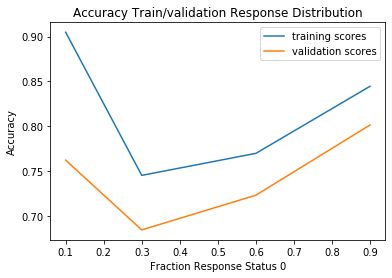

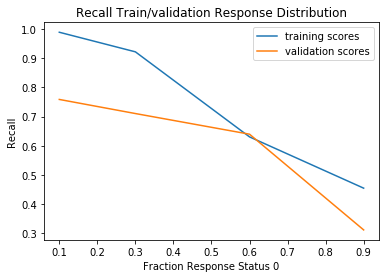

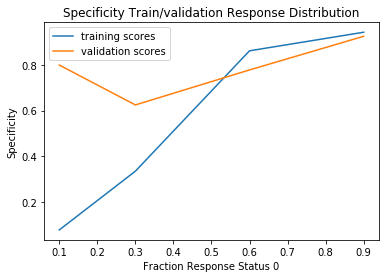

In [248]:
"""
Determine the impact of the fraction of rows with Resp=0 in the training data
on performance on the training and validation set.
We try 4 different fractions and then plot the results.
"""

# fraction_zeroes = [.1,.2,.4,.6]
fraction_zeroes = [.1,.3,.6,.9]
train_scores,valid_scores,train_confusion_matrices,valid_confusion_matrices, \
    train_recalls, valid_recalls, train_specificities, valid_specificities = \
        train_validate_model(fraction_zeroes)
plot_scores(fraction_zeroes,train_scores,valid_scores)
plot_scores(fraction_zeroes,train_recalls,valid_recalls,metric='Recall')
plot_scores(fraction_zeroes,train_specificities,valid_specificities,metric='Specificity')

As we created a more skewed distribution either by reducing or increasing the fraction of 0 responses in the training data, we achieved higher accuracies. This is expected behavior. The accuracy at the .9  0 response fraction was not as high as at the .1 end because as mentioned above we only vary the percentage by removing 0 response rows. Consequently, setting the fraction to .9 is equivalent to  it to leaving the original distribution unchanged. The original 0 response fraction is 
733/(733+187) = .8

Let's now see the effect of skew in the training data on the performance on the test data set.


In [249]:
from statistics import mean
def test_model(fraction_zeroes=[.1,.2,.4,.6]):
    """
    Train the model using the full training data without validation.
    We then test the trained model on the test data set and compute
    a score.
    We do this for each value in the fraction_zeroes parameter.
    
    Parameters
    ----------
    fraction_zero_labels :
        List of fractions. These represent the target fraction of
        rows in the training data with a label value of 0. We adjust the
        training data to have this distribution before each run.
        
    Returns
    -------
    train_scores :
        list of training data scores. One for each value in fraction_zero_labels
    test_scores :
        list of test data scores. One for each value in fraction_zero_labels
    """
    train_scores = []
    test_scores = []
    test_labels = get_test_labels()
    for fz in fraction_zeroes:
        train_wf = create_train_workflow(fz)
        test_wf = create_test_workflow(train_wf.nucleotide_vocabulary)
        tester = ModelTester(train_wf.structured_data, train_wf.pr_seq_data, train_wf.rt_seq_data,
                              train_wf.labels,
                                 test_wf.pr_seq_max_len, test_wf.rt_seq_max_len,
                              train_wf.nucleotide_vocabulary.size,
                                 train_wf.nucleotide_vocabulary.num_oov_buckets)
        score = tester.train_full_model()
        train_scores.append(score)
        score = tester.test_full_model(test_wf.structured_data, test_wf.pr_seq_data, test_wf.rt_seq_data,
                              test_labels)
        test_scores.append(score)
    return train_scores, test_scores

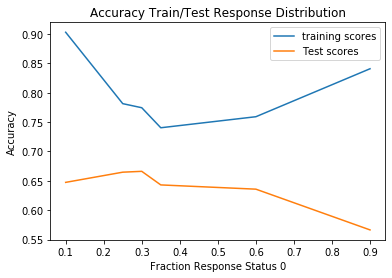

In [258]:
# fraction_zeroes = [.15,.2,.25,.3]
fraction_zeroes = [.1,.25,.3,.35,.6,.9]
train_scores,test_scores = test_model(fraction_zeroes)
plot_scores(fraction_zeroes,train_scores,test_scores,'Test')

In [261]:
max(test_scores)
#np.argmax(test_scores)

0.6661849710982659

In [252]:
labels = get_test_labels()
labels.value_counts()

1    346
0    346
Name: ResponderStatus, dtype: int64

The results shows how skew in the training set affects performance on the test set. The results indicate that a fraction of 0 response scores equal to .3 in the training set achieved the best results on the test data. The worse performance was achived with a fraction .9 which basically represents the original distribution in the training data. As mentioned above it was .8.

As shown above the actual fraction of 0 responses in the test solution file is .5. That is very different from the .8 found in the training data and also different from .3 in the modified training data which achieved the best performance on the test data.

This suggests that the training set response 0 data was not very representative of the test set response 0 data, while the training set response 1 data was more so.

The top score was .6661850. This places in the top 15 among the contestants of the original Kaggle competition.

I experimented with using RNN subnetworks for each of the nucleotide sequence inputs. The performance was substantially worse than CNN. Also using an Embedding layer rather than OneHot layer for the encoding was inferior.

As mentioned above, grouping the nucleotides into k-mers and encoding the kmers rather than the individual nucleotide bases is another option. However, a CNN with a kernel size larger than the stride has somewhat of a similar effect. In each case we are constructing features based upon overlapping subsequences.
